In [1]:
%%capture
!pip install datasets
!pip install transformers

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split

In [3]:
dataset = load_dataset('xed_en_fi','en_annotated')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/17528 [00:00<?, ? examples/s]

In [4]:
data = pd.DataFrame(dataset['train'])
data.head(5)

,sentence,labels
0,", ...",[1]
1,!,"[1, 4, 7]"
2,... And I don't think we need to discuss the T...,"[8, 1]"
3,* So get up out of your bed,[1]
4,A confession that you hired [PERSON] ... and a...,"[1, 6]"


In [5]:
attributes = [ 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 170, 174, 176, 177, 179, 182, 183, 184, 185, 188, 192, 193, 194, 196, 198, 202, 204, 207, 209, 216, 218, 221, 222, 228, 229, 251, 261, 281, 290, 299]


<BarContainer object of 193 artists>

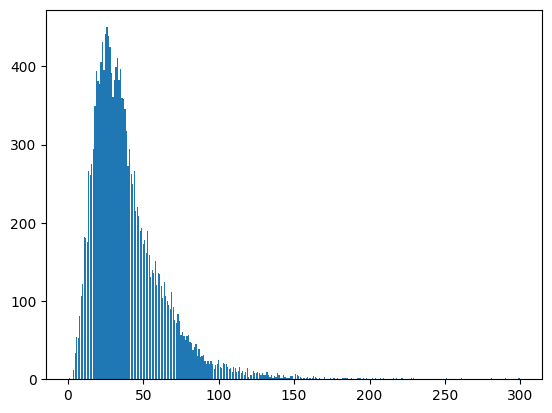

In [6]:
sentences_length = [len(sentence) for sentence in data['sentence']]
lens = list(set(sentences_length))
print(lens)
sen_count = pd.Series(sentences_length).value_counts().sort_index()
plt.bar(lens,sen_count.values)

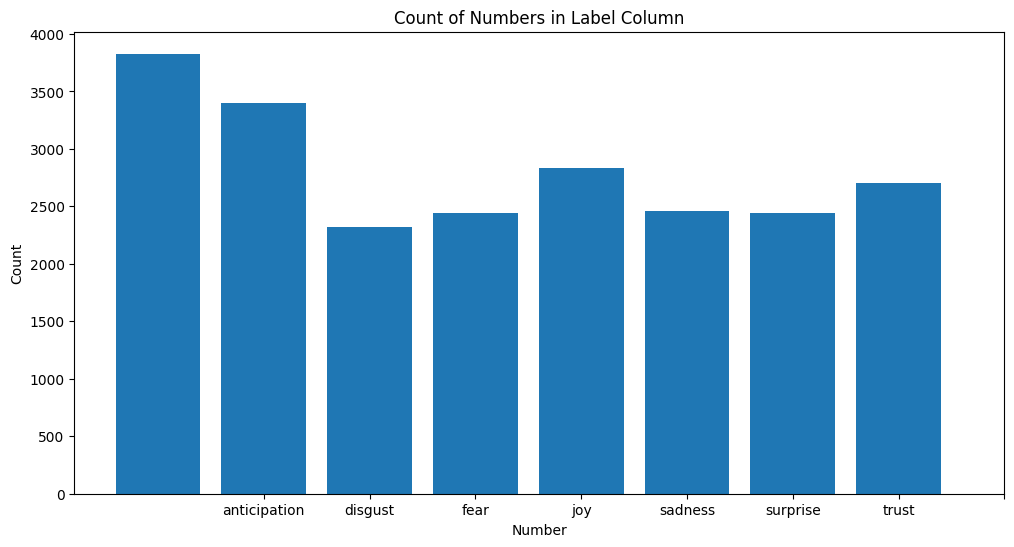

In [7]:
# Flatten the list of lists in the 'label' column
labels_flat = [item for sublist in data['labels'] for item in sublist]

# Count the occurrences of each number
label_counts = pd.Series(labels_flat).value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(attributes, label_counts.values)
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Count of Numbers in Label Column')
plt.xticks(range(1,9))  # Assuming the range is 1-8
plt.show()

In [8]:
class Em_Dataset(Dataset):
  def __init__(self,x,y,tokenizer):
    self.x = x
    self.y = self.one_hot_encoding(y)
    self.tokenizer = tokenizer

  def one_hot_encoding(self,labels):
    one_hot_encoded = []
    for label in labels:
      one_hot = [0] * 8
      for emotion in label:
        one_hot[emotion - 1] = 1
      one_hot_encoded.append(one_hot)
    return one_hot_encoded

  def __len__(self):
    assert len(self.x) == len(self.y)
    return len(self.x)

  def __getitem__(self,index):
    sentence = self.x.iloc[index]  # Use iloc to access rows by integer index
    labels = torch.FloatTensor(self.y[index])
    tokens = self.tokenizer(sentence,
                            add_special_tokens=True,
                            return_tensors = 'pt',
                            padding = 'max_length',
                            truncation = True,
                            max_length = 128,
                            return_attention_mask = True
                            )
    #2d list to 1d
    return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}

**Train Test Split**

In [9]:
x_train , x_test , y_train , y_test = train_test_split(data['sentence'],data['labels'],test_size=0.2,train_size=0.8)

In [10]:
print(type(y_train))

<class 'pandas.core.series.Series'>


**Importing Model And Tokenizer**

In [11]:
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
train_dataset = Em_Dataset(x_train,y_train,tokenizer)
test_dataset = Em_Dataset(x_test,y_test,tokenizer)

In [13]:
train_dataLoader = DataLoader(dataset=train_dataset,batch_size=4,num_workers=2,shuffle=True)
test_dataLoader = DataLoader(dataset=test_dataset,batch_size=4,num_workers=2,shuffle=True)

In [14]:
print(len(train_dataset))

14022


In [ ]:
for epoch in range(2):
  for batch_idx, batch in enumerate(train_dataLoader):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']

      # Print the content of each batch
      print("Batch Index:", batch_idx)
      print("Input IDs:", input_ids)
      print("Attention Mask:", attention_mask)
      print("Labels:", labels)
      print()
      break
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Batch Index: 0
Input IDs: tensor([[    0, 39008,  1958,  3064,    15,     5,  3627,   479,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,    

In [19]:
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel

class Emotion_Sentence_Classifier(nn.Module):

  def __init__(self,config : dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'],return_dict=True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,64)
    self.classifier = torch.nn.Linear(64,self.config['n_labels'])

    #initilizing weights
    torch.nn.init.xavier_uniform(self.classifier.weight)

    #loss function
    self.loss_func = nn.BCEWithLogitsLoss(reduction = 'mean')
    #BCE is the combination of cross entropy followed by the sigmoid function

    #droupout for model to avoid to be overfitted
    self.dropout = nn.Dropout()

    for param in self.pretrained_model.parameters():
            param.requires_grad = False

  def forward(self,input_ids,attention_mask,labels=None):
  #roberta layer
    output = self.pretrained_model(input_ids = input_ids,attention_mask = attention_mask)
    #print('output before avg-pooling: ',output)
    # batch size * sequence_length * hidden layer size
    pooled_output = torch.mean(output.last_hidden_state,1)
    #batch size * hidden layer size
    #print('after avg pooling : ',pooled_output)
    #my nn layer
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output) # relu activation function
    logits = self.classifier(pooled_output)
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1,self.config['n_labels']),labels.view(-1,self.config['n_labels']))
    return loss , logits




In [20]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 4,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'weight_decay': 0.001,
    'n_epochs': 10
}

model = Emotion_Sentence_Classifier(config)

<ipython-input-19-398022114ded>:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)


In [21]:
total_training_samples = len(x_test)
print(total_training_samples)

3506


In [22]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)
print(trainable_params/total_params * 100,'%')

Total parameters: 82168136
Trainable parameters: 49736
0.060529546392533475 %


**Training Loop**

In [23]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

criterion = nn.BCELoss()


for epoch in range(2):
    for i, ku in enumerate(train_dataLoader):
      print(i,')',end=' ')
      #forward propagation
      loss , logits = model(ku['input_ids'],ku['attention_mask'],ku['labels'])

      #back propagate
      loss.backward()

      #update weights
      optimizer.step()

      #clear gradients
      optimizer.zero_grad()

      print(loss , end = '\n')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : to

0 ) tensor(0.7053, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.6876, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.5712, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.4077, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.5965, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.3343, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.4053, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.5367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.4619, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.5471, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3325, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
11 ) tensor(0.7003, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
12 ) tensor(0.6462, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
13 ) tensor(0.3904, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
14 ) tensor(0.6728, grad_fn=<BinaryCrossEntr

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.4909, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.3535, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3878, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.4007, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.4344, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.3630, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.4445, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.4946, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.4248, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.3562, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3526, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
11 ) tensor(0.5403, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
12 ) tensor(0.5943, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
13 ) tensor(0.4082, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
14 ) tensor(0.3998, grad_fn=<BinaryCrossEntr

**Saving Model**

In [24]:
import torch

epoch = 2
learning_rate = 0.01


# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), 'Em_model_{}_{}.pth'.format(epoch,learning_rate))


**Saving To Drive**

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
import shutil

# Source path (where your model.pth file is located in Colab)
source_path =  'Em_model_{}_{}.pth'.format(epoch,learning_rate)

# Destination path in Google Drive
destination_path = "/content/drive/MyDrive/Emotion_Classifier/checkpoints/Em_model_{}_{}lr.pth".format(epoch,learning_rate)

# Copy the file
shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/Emotion_Classifier/checkpoints/Em_model_2_0.01lr.pth'

**Reloading Pre-Train-Model**

In [ ]:
import torch

# Define your model architecture (same as the one you used to train the model)
# For example:
# model = YourModel()

# Load the model's state dictionary
model_state_dict = torch.load( "/content/drive/MyDrive/Emotion_Classifier/checkpoints/Em_model_{}_{}lr.pth".format(epoch,learning_rate))

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()


Emotion_Sentence_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

**Accuracy After some Training**

In [27]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
number_of_correct_predictions = 0.0
with torch.no_grad():
  for epoch in range(1):
      for i, ku in enumerate(test_dataLoader):
        print(i,end=' ')
        _ , logits = model(ku['input_ids'],ku['attention_mask'],ku['labels'])
        predicted_emotions = torch.where(F.sigmoid(logits) > 0.5,torch.tensor(1),torch.tensor(0))
        correct_predictions = torch.eq(predicted_emotions,ku['labels'])
        number_of_correct_predictions += torch.sum(correct_predictions).item()


print('correct predicitons  : ',number_of_correct_predictions)

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [28]:
print('correct predictions : ',number_of_correct_predictions)
print('total outcomes',len(x_test) * 8)
print('Accuracy',round((number_of_correct_predictions)/(len(x_test) * 8) * 100,2),'%' )

correct predictions :  23465.0
total outcomes 28048
Accuracy 83.66 %


**Dont run these below CELLS!**

In [ ]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
number_of_correct_predictions = 0.0
with torch.no_grad():
  for epoch in range(1):
      for i, ku in enumerate(test_dataLoader):
        print(i,end=' ')
        _ , logits = model(ku['input_ids'],ku['attention_mask'],ku['labels'])
        predicted_emotions = torch.where(F.sigmoid(logits) > 0.5,torch.tensor(1),torch.tensor(0))
        correct_predictions = torch.eq(predicted_emotions,ku['labels'])
        number_of_correct_predictions += torch.sum(correct_predictions).item()


print('correct predicitons  : ',number_of_correct_predictions)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

**Accuracy Before Training**

In [ ]:
print('correct predictions : ',number_of_correct_predictions)
print('total outcomes',len(x_test) * 8)
print('Accuracy',round((number_of_correct_predictions)/(len(x_test) * 8) * 100,2),'%' )

correct predictions :  11989.0
total outcomes 28048
Accuracy 42.74 %
